In [1]:
import sys
import platform
from os.path import join, exists, abspath, dirname
from os import getcwd, makedirs
from glob import glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colormaps, cm, colors
import scipy
from sklearn.metrics import r2_score
import seaborn as sns

from tqdm import tqdm

In [2]:
import nibabel as nb
from nilearn import plotting, image
from nipype.interfaces import fsl

In [3]:
dir_current = getcwd().replace('\\','/')

tmp = dir_current.split('/')
idx = [ii for ii, s in enumerate(tmp) if s=='github'][0]

dir_git = '/'.join(tmp[:idx+1])
dir_git

'/home/sungbeenpark/github'

In [4]:
dname = join(dir_git,'nitools')
sys.path.append(dname)
import nitools as nt

In [5]:
dname = join(dir_git,'SUITPy')
sys.path.append(dname)
import SUITPy as suit

In [6]:
dname = join(dir_git)
sys.path.append(dname)
import surfAnalysisPy as surf

In [7]:
dname = join(dir_git,'SeqSpatialSupp_fMRI')
sys.path.append(dname)
from SSS import deal_spm
from SSS import util as su
from SSS import plot as splt
from SSS import image as simage
from SSS import glmsingle as ssingle

---

In [8]:
list_nn = su.get_list_sn()
list_roi = simage.get_list_roi()
list_run = su.get_list_run()

---

In [9]:
border = simage.get_border(join(dir_git,'surfAnalysisPy'))
hem = 'L'

---

In [10]:
glm = 2
dir_glm = join(ssingle.get_dir_glmsingle(glm))

---

In [11]:
dir_work = join(dir_glm,'surfaceWB')

In [12]:
subj = 'S01'

In [13]:
reginfo = deal_spm.load_reginfo(subj,dir_glm)
reginfo

,sn,run,name,ons
0,1,1,Rest,6.03
1,1,1,C_S,11.03
2,1,1,S_L,16.03
3,1,1,C_L,21.03
4,1,1,N_S,26.03
...,...,...,...,...
539,1,8,C_S,3215.03
540,1,8,S_L,3220.03
541,1,8,N_S,3225.03
542,1,8,S_L,3230.03


In [14]:
def get_df_idx(subj, glm):
    reginfo = deal_spm.load_reginfo(subj,dir_glm)
    df_idx = pd.DataFrame()
    df_idx['letter'] = np.array([True if '_L' in name else False for name in reginfo.name])
    df_idx['spatial'] = np.array([True if '_S' in name else False for name in reginfo.name])
    df_idx['B'] = np.array([True if 'B_' in name else False for name in reginfo.name])
    df_idx['S'] = np.array([True if 'S_' in name else False for name in reginfo.name])
    df_idx['C'] = np.array([True if 'C_' in name else False for name in reginfo.name])
    df_idx['N'] = np.array([True if 'N_' in name else False for name in reginfo.name])
    return df_idx

In [15]:
df_idx = get_df_idx(subj=subj, glm=glm)
df_idx

,letter,spatial,B,S,C,N
0,False,False,False,False,False,False
1,False,True,False,False,True,False
2,True,False,False,True,False,False
3,True,False,False,False,True,False
4,False,True,False,False,False,True
...,...,...,...,...,...,...
539,False,True,False,False,True,False
540,True,False,False,True,False,False
541,False,True,False,False,False,True
542,True,False,False,True,False,False


---

# Calculate Contrasts

In [65]:
dataset = {}
for ii, nn in enumerate(tqdm(list_nn)):
    subj = 'S'+nn

    ## index
    df_idx = get_df_idx(subj=subj, glm=glm)

    ## load beta
    fname = join(dir_work,subj,'%s.%s.glm_%d.beta.func.gii'%(subj,hem,glm))
    darrays = nb.load(fname).darrays
    data = np.ones((len(df_idx),32492)) * np.nan
    for jj, darray in enumerate(darrays):
        data[jj] = darray.data
    del darrays

    ## contrast
    for cue in ['letter', 'spatial']:
        if ii==0:
            dataset['wRS_'+cue] = np.ones((len(list_nn),32492))
            dataset['acRS_'+cue] = np.ones((len(list_nn),32492))
        idx_B = ((df_idx[cue])&(df_idx.B)).values.astype(int)
        idx_S = ((df_idx[cue])&(df_idx.S)).values.astype(int)
        idx_C = ((df_idx[cue])&(df_idx.C)).values.astype(int)
        idx_N = ((df_idx[cue])&(df_idx.N)).values.astype(int)
        ## within cue
        contrast = idx_B - idx_S
        dataset['wRS_'+cue][ii,:] = contrast@data
        ## across cue
        contrast = idx_C - idx_N
        dataset['acRS_'+cue][ii,:] = contrast@data

100%|███████████████████████████████████████████████████| 12/12 [01:10<00:00,  5.91s/it]


### within Cue

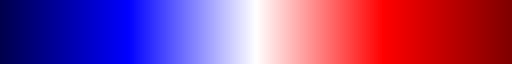

In [56]:
cmap = cm.seismic
cmap

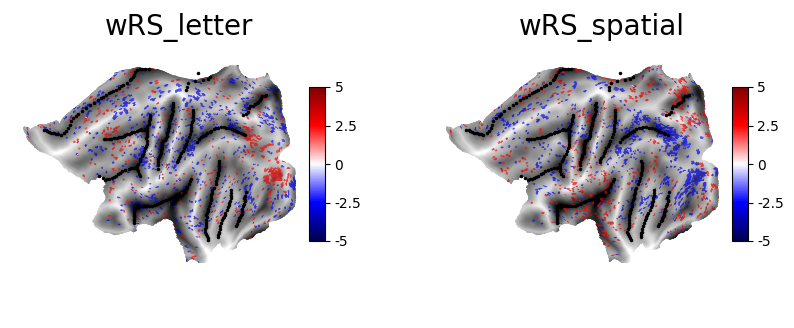

In [79]:
fig, axs = plt.subplots(ncols=2, figsize=(10,4))

for ii, sss in enumerate(['wRS_letter','wRS_spatial']):
    ax=axs[ii]
    plt.sca(ax)
    res = scipy.stats.ttest_1samp(dataset[sss], popmean=0, axis=0)
    thresh = su.convert_alpha_to_tval(alpha=0.05, df=res.df.mean())
    g = surf.plot.plotmap(
        data=res.statistic,
        surf='fs32k_%s'%hem,
        alpha=0.7,
        cmap=cmap, colorbar=True,
        cscale=[-5,5],
        threshold=[-thresh,thresh],
        borders=border, bordercolor='black', bordersize=3,
        overlay_type='func', render='matplotlib',
    )
    g.text(x=40, y=250, s=sss, ha='center', va='center', fontsize=20)

### across Cue

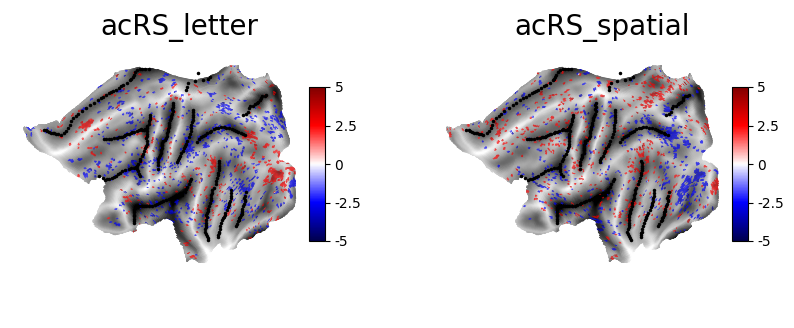

In [80]:
fig, axs = plt.subplots(ncols=2, figsize=(10,4))

for ii, sss in enumerate(['acRS_letter','acRS_spatial']):
    ax=axs[ii]
    plt.sca(ax)
    res = scipy.stats.ttest_1samp(dataset[sss], popmean=0, axis=0)
    thresh = su.convert_alpha_to_tval(alpha=0.05, df=res.df.mean())
    g = surf.plot.plotmap(
        data=res.statistic,
        surf='fs32k_%s'%hem,
        alpha=0.7,
        cmap=cmap, colorbar=True,
        cscale=[-5,5],
        threshold=[-thresh,thresh],
        borders=border, bordercolor='black', bordersize=3,
        overlay_type='func', render='matplotlib',
    )
    g.text(x=40, y=250, s=sss, ha='center', va='center', fontsize=20)

---